In [3]:
import pandas as pd

# 1. Cargar los datasets
df_pib = pd.read_csv("data_2025/pib2020-2025.csv")
df_who = pd.read_csv("data_2025/WHO_life_expectancy.csv")

# 2. Limpiar datos de la OMS (el paso más crítico)
# Extraer el valor numérico, ej: "48.7 [47.8-49.7]" -> 48.7
df_who['Life_Exp'] = df_who['Value'].str.split(' ', expand=True)[0].astype(float)

# Filtrar para obtener datos consistentes
indicator_filter = 'Life expectancy at birth (years)'
sex_filter = 'Both sexes'
df_who_clean = df_who[
    (df_who['Indicator'] == indicator_filter) &
    (df_who['Dim1'] == sex_filter)
].copy()

# Seleccionar y renombrar columnas para la unión
df_who_clean = df_who_clean[['Location', 'Period', 'Life_Exp']]
df_who_clean.rename(columns={'Location': 'Country', 'Period': 'Year'}, inplace=True)

# 3. Transformar datos del PIB (de formato ancho a largo)
df_pib_long = df_pib.melt(
    id_vars=['Country'],
    var_name='Year',
    value_name='GDP'
)
# Asegurarse de que el tipo de 'Year' coincida
df_pib_long['Year'] = df_pib_long['Year'].astype(int)

# 4. Unir (Merge) los DataFrames
df_master = pd.merge(
    df_pib_long,
    df_who_clean,
    on=['Country', 'Year'],
    how='inner' # 'inner' solo mantiene filas que coinciden en ambos
)

# 5. Manejo de Nulos (Post-Unión)
# (Para ML, es crucial no tener nulos en las columnas que usarás)
df_master.dropna(subset=['GDP', 'Life_Exp'], inplace=True)

print("DataFrame maestro listo:")
print(df_master.head())

DataFrame maestro listo:
               Country  Year       GDP  Life_Exp
0          Afghanistan  2020   20136.0      60.5
1              Albania  2020   15271.0      76.5
2              Algeria  2020  164774.0      74.0
3               Angola  2020   66521.0      62.6
4  Antigua and Barbuda  2020    1412.0      77.6


EDA

Estadísticas Descriptivas:
                GDP    Life_Exp
count  3.210000e+02  321.000000
mean   3.664041e+05   71.520561
std    1.458291e+06    7.324817
min    2.220000e+02   51.500000
25%    1.222200e+04   66.100000
50%    3.820900e+04   72.600000
75%    2.105410e+05   76.800000
max    1.819080e+07   84.700000

Correlación de Pearson (GDP vs Life_Exp): 0.2138
Histograma guardado en 'histograma_esperanza_vida.png'
Gráfico de dispersión guardado en 'scatter_gdp_vs_life_exp.png'


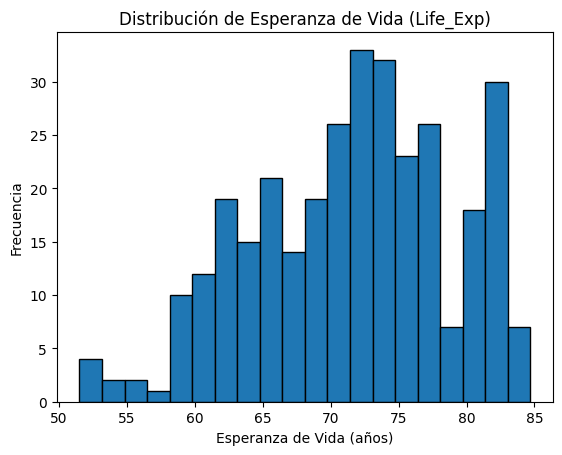

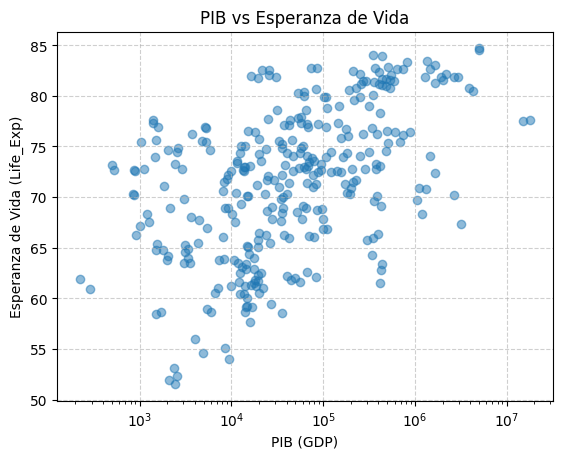

In [4]:
import matplotlib.pyplot as plt

# 1. Estadísticas Descriptivas (Ref: PDF 14)
print("Estadísticas Descriptivas:")
print(df_master[['GDP', 'Life_Exp']].describe())

# 2. Correlación de Pearson (Ref: PDF 14)
correlation = df_master['GDP'].corr(df_master['Life_Exp'])
print(f"\nCorrelación de Pearson (GDP vs Life_Exp): {correlation:.4f}")

# 3. Histograma de Esperanza de Vida (Ref: PDF 15)
plt.figure()
plt.hist(df_master['Life_Exp'], bins=20, edgecolor='black')
plt.title('Distribución de Esperanza de Vida (Life_Exp)')
plt.xlabel('Esperanza de Vida (años)')
plt.ylabel('Frecuencia')
plt.savefig('histograma_esperanza_vida.png')
print("Histograma guardado en 'histograma_esperanza_vida.png'")

# 4. Gráfico de Dispersión (GDP vs Life_Exp) (Ref: PDF 16)
plt.figure()
plt.scatter(df_master['GDP'], df_master['Life_Exp'], alpha=0.5)
plt.title('PIB vs Esperanza de Vida')
plt.xlabel('PIB (GDP)')
plt.ylabel('Esperanza de Vida (Life_Exp)')
# El PIB suele necesitar escala logarítmica para una mejor visualización
plt.xscale('log') 
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig('scatter_gdp_vs_life_exp.png')
print("Gráfico de dispersión guardado en 'scatter_gdp_vs_life_exp.png'")

Aprendizaje de Máquinas (ML)

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report

# --- TAREA A: REGRESIÓN (Predecir 'Life_Exp' usando 'GDP') ---
print("\n--- INICIANDO TAREA DE REGRESIÓN ---")

# 1. Preparar datos X e y
X_reg = df_master[['GDP']]      # Features (siempre 2D)
y_reg = df_master['Life_Exp']   # Target (1D)

# 2. Dividir en Train/Test
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

# 3. Entrenar modelo de Regresión Lineal (Ref: PDF 19)
reg_model = LinearRegression()
reg_model.fit(X_reg_train, y_reg_train)
print("Modelo de Regresión Lineal entrenado.")

# 4. Evaluar modelo de Regresión (Ref: PDF 19)
y_reg_pred = reg_model.predict(X_reg_test)
mse = mean_squared_error(y_reg_test, y_reg_pred)
r2 = r2_score(y_reg_test, y_reg_pred)

print(f"  Resultados (Regresión):")
print(f"    Error Cuadrático Medio (MSE): {mse:.4f}")
print(f"    Coeficiente de Determinación (R^2): {r2:.4f}")


# --- TAREA B: CLASIFICACIÓN (Predecir 'High_Life' usando 'GDP') ---
print("\n--- INICIANDO TAREA DE CLASIFICACIÓN ---")

# 1. Crear la variable objetivo categórica (Target)
# Usamos la mediana (72.6 años) como umbral
median_life_exp = df_master['Life_Exp'].median()
df_master['High_Life'] = (df_master['Life_Exp'] > median_life_exp).astype(int)
print(f"Variable 'High_Life' creada (1 si > {median_life_exp}, 0 si no)")

# 2. Preparar datos X e y
X_class = df_master[['GDP']]      # Features
y_class = df_master['High_Life']  # Target (categórico)

# 3. Dividir en Train/Test
X_class_train, X_class_test, y_class_train, y_class_test = train_test_split(
    X_class, y_class, test_size=0.2, random_state=42, stratify=y_class
)

# 4. Modelo 1: Regresión Logística (Ref: PDF 21)
log_model = LogisticRegression()
log_model.fit(X_class_train, y_class_train)
y_log_pred = log_model.predict(X_class_test)

print("\n  Resultados (Regresión Logística):")
print(f"    Accuracy: {accuracy_score(y_class_test, y_log_pred):.4f}")
print(classification_report(y_class_test, y_log_pred))

# 5. Modelo 2: Árbol de Decisión (Ref: PDF 23)
# Usamos max_depth=3 para evitar overfitting (mencionado en PDF 23)
tree_model = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_model.fit(X_class_train, y_class_train)
y_tree_pred = tree_model.predict(X_class_test)

print("\n  Resultados (Árbol de Decisión):")
print(f"    Accuracy: {accuracy_score(y_class_test, y_tree_pred):.4f}")
print(classification_report(y_class_test, y_tree_pred))


--- INICIANDO TAREA DE REGRESIÓN ---
Modelo de Regresión Lineal entrenado.
  Resultados (Regresión):
    Error Cuadrático Medio (MSE): 42.2504
    Coeficiente de Determinación (R^2): -0.0038

--- INICIANDO TAREA DE CLASIFICACIÓN ---
Variable 'High_Life' creada (1 si > 72.6, 0 si no)

  Resultados (Regresión Logística):
    Accuracy: 0.6308
              precision    recall  f1-score   support

           0       0.58      0.94      0.72        33
           1       0.83      0.31      0.45        32

    accuracy                           0.63        65
   macro avg       0.71      0.63      0.59        65
weighted avg       0.71      0.63      0.59        65


  Resultados (Árbol de Decisión):
    Accuracy: 0.6308
              precision    recall  f1-score   support

           0       0.68      0.52      0.59        33
           1       0.60      0.75      0.67        32

    accuracy                           0.63        65
   macro avg       0.64      0.63      0.63        65
we